# **MBP1413H MONAI Tutorial With Google Colab**
This tutorial was written by [Ahmadreza Attarpour](https://github.com/AAttarpour) for MBP1413H.

I used sections of [this tutorial](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb) from MONAI.

# **Introduction**
MONAI short for Medical Open Network for AI, is an open-source, community-driven framework for deep learning in medical imaging. It is designed to accelerate the development and deployment of AI models in the field of healthcare, with a specific focus on medical imaging applications.



# **MONAI overview**

* ***Community-Driven Framework:*** MONAI is developed and maintained by a collaborative community of researchers, engineers, and healthcare professionals. It is *open-source* and freely available for use and contributions.

* ***Medical Imaging Focus:*** MONAI is tailored for the unique challenges and requirements of medical imaging tasks, such as segmentation, classification, registration, and more.

* ***PyTorch Integration:*** MONAI is built on top of PyTorch, a popular deep learning framework. This integration leverages PyTorch's capabilities while offering additional functionalities tailored for medical imaging.

# **MONAI key features**

* ***Data Handling:*** MONAI provides data loaders and handlers specifically designed for medical imaging datasets. It supports multi-modal and 3D data, addressing the unique characteristics of medical images.

* ***Transforms and Augmentations:*** MONAI offers a variety of image transforms and augmentations optimized for medical imaging tasks. These can be easily applied to the data during training and evaluation.

* ***Pre-built Components:*** MONAI includes pre-built components for common medical imaging tasks, such as pre-processing, post-processing, and model evaluation. This accelerates the development process and encourages best practices.

* ***Model Zoo:*** MONAI has a model zoo containing pre-trained models for various medical imaging tasks. Users can leverage these models as a starting point for their projects or fine-tune them for specific datasets.

* ***Community Support:*** Being an open-source project, MONAI benefits from a growing community of users and contributors. The community actively shares knowledge, code, and resources related to medical imaging and deep learning.

# **Getting Started with MONAI**

Useful links:


1.   [MONAI official website](https://monai.io/)
2.   [Project MONAI](https://docs.monai.io/en/stable/index.html)
3.   [Github page](https://github.com/Project-MONAI)
4.   [Tutorials](https://github.com/Project-MONAI/tutorials)




# **Section 1: Setup environment**




In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 2.9 MB/s eta 0:00:00


In [19]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.4.dev2403
Numpy version: 1.23.5
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 0d5dc508eebc2e844bb4be7b5ef83abb60a2c4e6
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.1
gdown version: 4.6.3
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.35.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpncgfi7oa


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.


* Task: Spleen segmentation
* Target: Spleen  
* Modality: CT  
* Size: 61 3D volumes (41 Training + 20 Testing)  
* Source: Memorial Sloan Kettering Cancer Center  
* Challenge: Large ranging foreground size

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [00:58, 27.5MB/s]                            

2024-01-24 16:19:31,258 - INFO - Downloaded: /tmp/tmpncgfi7oa/Task09_Spleen.tar


2024-01-24 16:19:34,360 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2024-01-24 16:19:34,361 - INFO - Writing into directory: /tmp/tmpncgfi7oa.


In [5]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [6]:
print(f"training data: {train_files}")
print(f"validating data: {val_files}")

training data: [{'image': '/tmp/tmpncgfi7oa/Task09_Spleen/imagesTr/spleen_10.nii.gz', 'label': '/tmp/tmpncgfi7oa/Task09_Spleen/labelsTr/spleen_10.nii.gz'}, {'image': '/tmp/tmpncgfi7oa/Task09_Spleen/imagesTr/spleen_12.nii.gz', 'label': '/tmp/tmpncgfi7oa/Task09_Spleen/labelsTr/spleen_12.nii.gz'}, {'image': '/tmp/tmpncgfi7oa/Task09_Spleen/imagesTr/spleen_13.nii.gz', 'label': '/tmp/tmpncgfi7oa/Task09_Spleen/labelsTr/spleen_13.nii.gz'}, {'image': '/tmp/tmpncgfi7oa/Task09_Spleen/imagesTr/spleen_14.nii.gz', 'label': '/tmp/tmpncgfi7oa/Task09_Spleen/labelsTr/spleen_14.nii.gz'}, {'image': '/tmp/tmpncgfi7oa/Task09_Spleen/imagesTr/spleen_16.nii.gz', 'label': '/tmp/tmpncgfi7oa/Task09_Spleen/labelsTr/spleen_16.nii.gz'}, {'image': '/tmp/tmpncgfi7oa/Task09_Spleen/imagesTr/spleen_17.nii.gz', 'label': '/tmp/tmpncgfi7oa/Task09_Spleen/labelsTr/spleen_17.nii.gz'}, {'image': '/tmp/tmpncgfi7oa/Task09_Spleen/imagesTr/spleen_18.nii.gz', 'label': '/tmp/tmpncgfi7oa/Task09_Spleen/labelsTr/spleen_18.nii.gz'}, {'im

## Set deterministic training for reproducibility

In [7]:
set_determinism(seed=0)

# **Section 2:  Set up data loader and augmentation transforms**


## MONAI [transforms](https://docs.monai.io/en/latest/transforms.html)


Image is loaded; shape is torch.Size([512, 512, 55])
Label is loaded; shape is torch.Size([512, 512, 55])


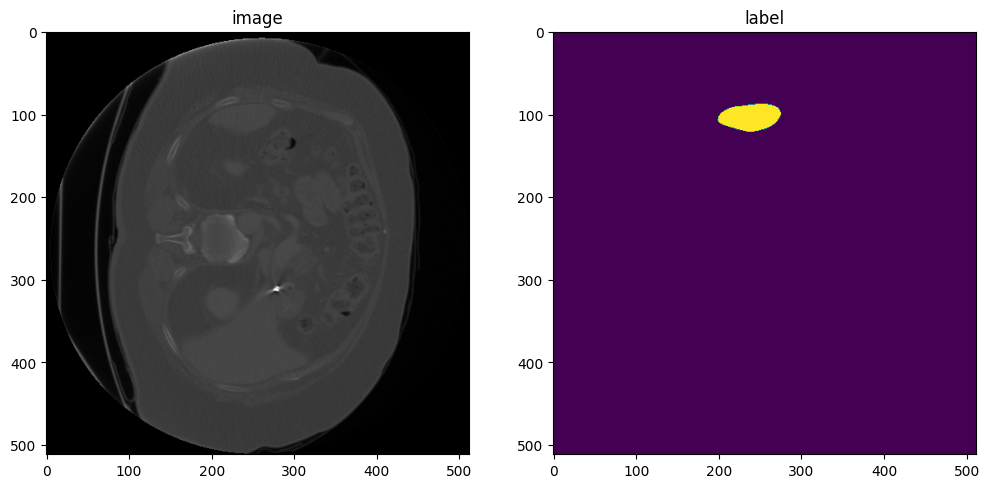

In [8]:
# how transforms work
# define transform1
transform1 = LoadImaged(keys=["image", "label"])
# call transform1
data1 = transform1(train_files[0])
print(f"Image is loaded; shape is {data1['image'].shape}")
print(f"Label is loaded; shape is {data1['label'].shape}")

# Plot a slice of the images and labels (slice along the third dimension at index 80)
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(data1['image'][:, :, 25], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(data1['label'][:, :, 25])
plt.show()

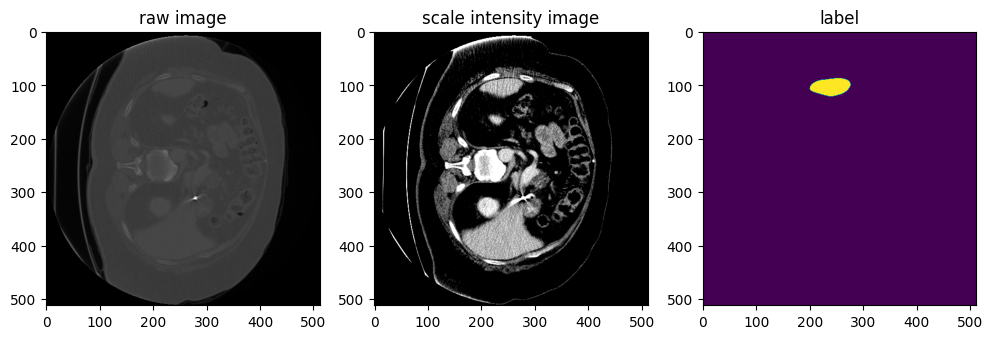

In [9]:
transform2 = ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True)
data2 = transform2(data1)
# Plot a slice of the images and labels (slice along the third dimension at index 80)
plt.figure("check", (12, 6))
plt.subplot(1, 3, 1)
plt.title("raw image")
plt.imshow(data1['image'][:, :, 25], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("scale intensity image")
plt.imshow(data2['image'][:, :, 25], cmap="gray")
plt.subplot(1, 3, 3)
plt.title("label")
plt.imshow(data2['label'][:, :, 25])
plt.show()

## Transforms using MONAI Compose
we can create a compose file that contains the list of all transforms we want to apply on each image.
1. LoadImaged:serves as the initial step in the data augmentation process, importing both spleen CT images and their corresponding labels from NIfTI format files. This step is crucial for accessing the raw medical imaging data required for subsequent transformations.
2. EnsureChannelFirstd:plays a pivotal role in data organization by rearranging the dimensions of the original data to adhere to the "channel first" format. This format is particularly important for compatibility with deep learning models.
3. Orientationd:standardizes the orientation of the data by leveraging information from the affine matrix. This ensures consistent alignment across different images, contributing to a uniform representation for downstream tasks.
4. Spacingd:facilitates the adjustment of voxel spacing within the medical images, a crucial step for maintaining spatial consistency. The specified pixel dimensions, controlled by the pixdim parameter, are derived from the underlying affine matrix.
5. ScaleIntensityRanged:undertakes the task of extracting intensity information within the range of [-57, 164], subsequently normalizing these values to a standardized scale of [0, 1]. This normalization ensures a consistent intensity distribution across all images.
6. CropForegroundd:eliminates extraneous zero borders from both images and corresponding labels. This action centers the focus solely on the valid body area within the images, excluding unnecessary background regions.
7. RandCropByPosNegLabeld:introduces randomness by extracting patch samples from larger images, with the selection process guided by a specified positive-to-negative ratio. Importantly, the centers of negative samples are constrained to lie within the valid body area, ensuring the relevance of generated training samples.
8. RandAffined:demonstrates efficiency in applying a combination of affine transformations, such as rotation, scaling, shearing, and translation, using PyTorch's affine transform capabilities. This versatile transform enhances the variability of the augmented dataset, contributing to the robustness of the trained model.


In [10]:
# Define training transforms
train_transforms = Compose(
    [
        # Load image and label data
        LoadImaged(keys=["image", "label"]),
        # Ensure channel is the first dimension
        EnsureChannelFirstd(keys=["image", "label"]),
        # Scale intensity values of the image within the specified range
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        # Crop foreground from the image and label using the source image
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # Adjust the orientation of the image and label using RAS (Right, Anterior, Superior) axcodes
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Adjust the spacing of the image and label using specified pixel dimensions and interpolation modes
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        # Randomly crop regions with positive and negative labels to create training samples
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # Optionally, user can add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)

# Define validation transforms
val_transforms = Compose(
    [
        # Load image and label data
        LoadImaged(keys=["image", "label"]),
        # Ensure channel is the first dimension
        EnsureChannelFirstd(keys=["image", "label"]),
        # Scale intensity values of the image within the specified range
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        # Crop foreground from the image and label using the source image
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # Adjust the orientation of the image and label using RAS (Right, Anterior, Superior) axcodes
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Adjust the spacing of the image and label using specified pixel dimensions and interpolation modes
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Check transforms in DataLoader and plot one sample image

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


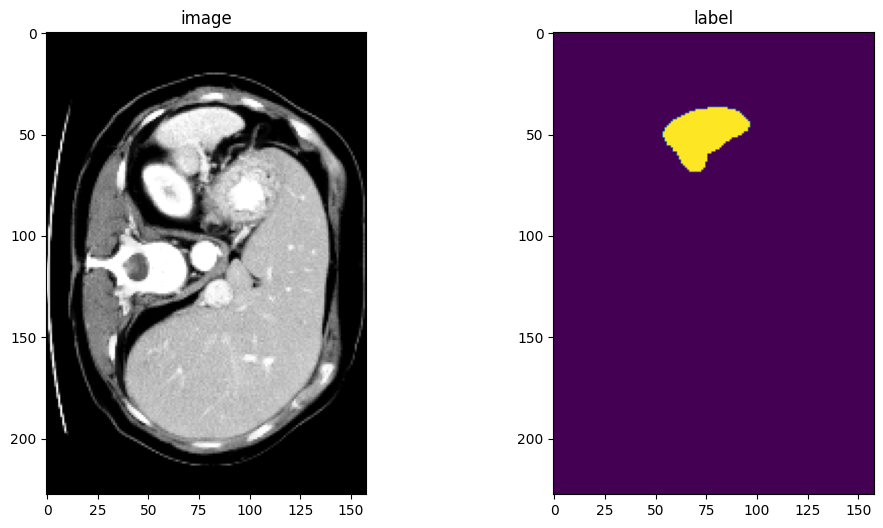

In [11]:
# Create a dataset using validation files and the specified validation transforms
check_ds = Dataset(data=val_files, transform=val_transforms)

# Create a DataLoader with a batch size of 1 for visualization purposes
check_loader = DataLoader(check_ds, batch_size=1)

# Retrieve the first batch of data from the DataLoader
check_data = first(check_loader)

# Extract the image and label from the data
image, label = (check_data["image"][0][0], check_data["label"][0][0])

# Print the shapes of the image and label
print(f"image shape: {image.shape}, label shape: {label.shape}")

# Plot a slice of the images and labels (slice along the third dimension at index 80)
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()


## Define CacheDataset and DataLoader for training and validation

In this section, we leverage the `CacheDataset` to significantly enhance the speed of both the training and validation processes, offering a remarkable 10x acceleration compared to the conventional Dataset. To optimize performance, consider setting the `cache_rate` parameter to 1.0, enabling the caching of the entire dataset. In cases where memory constraints arise, users have the flexibility to choose a lower value for `cache_rate`. Alternatively, the option to use `cache_num` is available, allowing the system to utilize the minimum value between `cache_num` and `cache_rate`. Moreover, for those seeking to employ multi-threading capabilities during caching, the `num_workers` parameter can be configured accordingly.

Should the desire arise to revert to the conventional Dataset for experimentation or comparison purposes, simply uncomment the provided code block below.

This approach not only streamlines the training and validation procedures but also offers a dynamic and adaptable caching mechanism tailored to the user's memory constraints and processing preferences.

In [12]:
# Create a CacheDataset for training with accelerated caching
# CacheRate is set to 1.0, caching the entire dataset for optimal performance
# NumWorkers enables multi-threading during caching for faster data loading
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)

# Alternatively, for experimentation with the regular Dataset, uncomment the line below:
# train_ds = Dataset(data=train_files, transform=train_transforms)

# Use DataLoader to load training data in batches of size 2
# Shuffle the data for randomization and apply RandCropByPosNegLabeld for data augmentation
# The resulting batch size will be 2 x 4, generating 2 batches of 4 images each for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

# Create a CacheDataset for validation with accelerated caching
# Similar to training, CacheRate is set to 1.0, caching the entire dataset for optimal performance
# NumWorkers enables multi-threading during caching for faster data loading
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)

# Alternatively, for experimentation with the regular Dataset, uncomment the line below:
# val_ds = Dataset(data=val_files, transform=val_transforms)

# Use DataLoader to load validation data in batches of size 1
# NumWorkers enables multi-threading during data loading for faster processing
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 32/32 [02:00<00:00,  3.76s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 9/9 [00:27<00:00,  3.02s/it]


During the training we loop over each image from train images, move it to GPU, apply our model on it, get the output, compare it against GT, compute loss, and apply backpropagation.
How can we loop over training data and each time apply all the data augmentation transforms we defined?

In [14]:
device = torch.device("cuda:0")

for batch_data in train_loader:
    inputs, labels = (
        batch_data["image"].to(device),
        batch_data["label"].to(device),
    )
    print(f"Input image shape: {inputs.shape}") # shouldn B x C X H X W X D
    print(f"Input label shape: {labels.shape}")
    break

Input image shape: torch.Size([8, 1, 96, 96, 96])
Input label shape: torch.Size([8, 1, 96, 96, 96])


# **Question**
Why B = 8 while we defined `batch_size=2` in the data loader?

# **Section 3:  Create model**
We are using UNET model, the most commonly used CNN model used for segmentation tasks in medical imaging. UNET architecture is characterized by its U-shaped structure, consisting of an encoding path for feature extraction and a symmetric decoding path for precise localization and segmentation. This architecture has proven effective in various medical image segmentation challenges, making it a popular choice for tasks such as organ segmentation, tumor detection, and anatomical structure identification. Its inherent ability to capture both local and global context makes UNET well-suited for complex and detailed segmentation tasks commonly encountered in medical image analysis.

In [16]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
print(model)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


# **Section 4:  Define loss function**
MONAI has implemented different type of loss function as `class` object for us.

Check [this link](https://docs.monai.io/en/latest/losses.html) for all the available loss functions in MONAI.

In this tutorial, we use [DiceLoss](https://docs.monai.io/en/latest/losses.html#diceloss), the most commonly used one in segmentation task.

In [17]:
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
# apply forward
outputs = model(inputs)
print(f"outputs outputs shape: {outputs.shape}")
loss = loss_function(outputs, labels)
print(f"train_loss: {loss.item():.4f}")

outputs outputs shape: torch.Size([8, 2, 96, 96, 96])
train_loss: 0.6610


# **Question**
Why does the output of the model have two channels (B x 2 X H X W X D)?

# **Section 5:  Evaluation metrics**

During training and also in inference mode, we need to evaluate our model either on validation or test sets to check/test the generalizability of our model. To do this we need some metrics.

Check [this link](https://docs.monai.io/en/0.8.0/metrics.html) for all the available evaluation metrics in MONAI.

In this tutorial, we use [Dice coefficient](https://docs.monai.io/en/0.8.0/metrics.html#mean-dice), the most commonly used one in segmentation task.

In [20]:
dice_metric = DiceMetric(include_background=False, reduction="mean") # Q. why do we set include_background to False?

In [21]:
# let's get one sample from validation dataset (similar to what we have done for training data)
model.eval() # set the model to inference mode
with torch.no_grad(): # in inference mode we don't need gradients. Q. Why?
  for val_data in val_loader:
      val_inputs, val_labels = (
          val_data["image"].to(device),
          val_data["label"].to(device),
      )
      print(f"Input image shape: {val_inputs.shape}") # shouldn B x C X H X W X D
      print(f"Input label shape: {val_labels.shape}")
      break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Input image shape: torch.Size([1, 1, 228, 158, 113])
Input label shape: torch.Size([1, 1, 228, 158, 113])


Let's get the model output on the sample image we got from validatation dataset. We can use [sliding window inference](https://docs.monai.io/en/latest/inferers.html#sliding-window-inference-function) approch, which allows us to process large images in a memory-efficient manner by dividing them into overlapping patches. This method is particularly beneficial when working with high-resolution medical images, enabling us to make predictions for each patch and seamlessly reconstruct the final output. The sliding window inference approach is instrumental in handling diverse image sizes and efficiently applying the model to entire datasets without memory constraints.

In [22]:
roi_size = (160, 160, 160)
sw_batch_size = 4
# get the model output on the validation data
val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
print(f"val_outputs image shape: {val_outputs.shape}")

val_outputs image shape: torch.Size([1, 2, 228, 158, 113])


Now let's prepare the outputs and calculate the dice score on model output.

In [23]:
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
val_labels = [post_label(i) for i in decollate_batch(val_labels)]
# compute metric for current iteration
dice_metric(y_pred=val_outputs, y=val_labels)
# aggregate the final mean dice result; this is useless now as we computed the
# dice only on image patch, but we need it when we go over all images
metric = dice_metric.aggregate().item()
# reset the status for next validation round
dice_metric.reset()
print(f"current mean dice: {metric:.4f}")

current mean dice: 0.0116


# **Question**
1. Why do we need `post_pred` and `post_label`?
2. Why is the mean dice too low?

# **Stay tuned for the next tutorial to see how like a puzzle we can use all of these modules from MONAI and PyTorch and develop and evaluate a model 🔥**